# NYC Neighborhood Accessibiliy and Livability Clustering

In [1]:
ANALYSIS_VERSION = "9v"

## Intro

Groups New York City neighborhoods (PUMAs) together based on characteristics measuring access and livability.

Analysis conducted by Mike Carper

Data prepared by NYC Planning's Enterprise Data Management team and downloaded from Equitable Development Data Explorer repository (https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources)

Input Variables to be considered for clustering (all ACS 2015-2019 5-Year variables, unless otherwise noted):
    
    * Park access: % of population with access to a park
    * Job access: jobs accessible within 30 mins by transit per 100 labor force participants, maxed at 100
    * Access to transit: % of population within 1/4 Mile of Subway Stations and SBS Stops (ACS 2017-2021 5-Year)
    * Affordable housing: % of households paying <30% of HH income,
              <50% of HH income
    * Home ownership: % of units that are owner-occupied
    * Broadband access: % of households with a computer
    * Computer access: % of households with broadband access
    * Employment rate: % of labor force participants 16 to 64 years old who are employed
    * Education: % of population 25 years and older with a bachelor's degree or higher,
             HS diploma
    * Infant mortality rate (ACS 2016-2020 5-Year)
    * Heat Vulnerability Index

## Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import geopandas as gpd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist, pdist
import scipy.cluster.hierarchy as shc

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
local_modules_path = os.path.abspath(os.path.join('../'))
sys.path.insert(0, local_modules_path)

from utilities.data_io import load_data_file, save_data_file, save_figure
from utilities.aggrgation import clean_cluster_outputs, round_percentage_data, set_cluster_labels

## Load Data Sets
Downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

In [6]:
OUTPUT_PATH_PREFIX = f"../outputs/{ANALYSIS_VERSION}/cluster_{ANALYSIS_VERSION}_"

In [7]:
path = '../data/'
job_access_path = 'access_to_jobs.csv'
housing_path = 'EDDT_ACS2015-2019.xlsx'
race_dec_path = 'EDDT_Census00-10-20_MUTU.xlsx'
demog_19_path = 'EDDT_Dem_ACS2015-2019.xlsx'
hh_econ_path = 'EDDT_HHEconSec_ACS2015-2019.xlsx'
units_aff_path = 'EDDT_UnitsAffordablebyAMI_2015-2019.xlsx'
dri_path = 'Equitable.Development.Data.Tool.-.Displacement.Risk.Index.2-8-2022.1.xlsx'
park_access_path = 'Park_Access.xlsx'
transit_parks_path = 'EDDE_2023_Updates_transportation.xlsx'
hvi_path = 'HVI_PUMA_Subboro_forSharing.xlsx'
mort_rate_path = 'DOHMH_death rate and overdose.xlsx'

In [8]:
boro_names = ['NYC','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [9]:
park_access = load_data_file(f'{path}{park_access_path}')
park_access = park_access.loc[~park_access['PUMA'].isin(boro_names)]
park_access.rename(columns={'Perc':'park_perc','PUMA':'PUMA_short'},inplace=True)
park_access['PUMA'] = '360'+park_access['PUMA_short'].astype(str)
park_access.head(3)

,PUMA_short,Pop_Served,Total_Pop20,park_perc,PUMA
0,3701,104085,113700,91.543536,3603701
1,3702,94287,148709,63.403694,3603702
2,3703,61828,123837,49.926920,3603703


In [10]:
hh_econ = load_data_file(f'{path}{hh_econ_path}')
hh_econ = hh_econ.loc[~hh_econ['Geog'].isin(boro_names)]
hh_econ['PUMA'] = '360'+hh_econ['Geog'].astype(str)
hh_econ.head(3)

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z,PUMA
6,3701,77539,1586,1.2,100,NaN,14093,1163,5.0,18.2,...,NaN,NaN,NaN,NaN,139284.0,162682.0,71.0,NaN,NaN,3603701
7,3702,101302,1996,1.2,100,NaN,19953,1337,4.1,19.7,...,NaN,NaN,NaN,NaN,13735.0,37476.0,165.9,NaN,NaN,3603702
8,3703,87544,2326,1.6,100,NaN,14779,1623,6.7,16.9,...,120584.0,473.0,NaN,NaN,22498.0,19396.0,52.4,NaN,NaN,3603703


In [11]:
hh_econNYC = load_data_file(f'{path}{hh_econ_path}')
hh_econNYC = hh_econNYC.loc[hh_econNYC['Geog']=='NYC']
hh_econNYC.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19E,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z
0,NYC,5935339,4567,0.0,100,NaN,1063104,11063,0.6,17.9,...,19258.0,1010.0,3.2,NaN,NaN,68710.0,4414.0,3.9,NaN,NaN


In [12]:
job_access = load_data_file(f'{path}{job_access_path}')
job_access['PUMA'] = job_access['PUMA'].astype(str)
job_access = job_access.loc[~job_access['PUMA'].isin(boro_names)]
job_access = pd.merge(job_access,hh_econ[['PUMA','LF_19E']],how='left',on='PUMA')
# new variable: # of jobs accessible per 100 labor force participants
job_access['job_perc'] = (job_access[
    'Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit']*100)/job_access['LF_19E']
# change values over 100 to 100
job_access['job_perc'] = np.where(job_access['job_perc'] < 100, job_access['job_perc'], 100) 
job_access.head(3)

,PUMA,Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit,LF_19E,job_perc
0,3603701,45439,50545,89.898111
1,3603702,33763,72051,46.859863
2,3603703,20265,55725,36.366083


In [13]:
housing = load_data_file(f'{path}{housing_path}')
housing = housing.loc[~housing['Geog'].isin(boro_names)]
housing['PUMA'] = '360'+housing['Geog'].astype(str)
housing.head(3)

,Geog,OcHU1_19E,OcHU1_19M,OcHU1_19C,OcHU1_19P,OcHU1_19Z,OOcc1_19E,OOcc1_19M,OOcc1_19C,OOcc1_19P,...,Comp_A19M,Comp_A19C,Comp_A19P,Comp_A19Z,BbInt_A19E,BbInt_A19M,BbInt_A19C,BbInt_A19P,BbInt_A19Z,PUMA
6,3701,42884,645,0.9,100,NaN,13347,817,3.7,31.1,...,256,10.7,92.9,5.1,1289,236,11.1,82.5,6.0,3603701
7,3702,50543,607,0.7,100,NaN,19234,945,3.0,38.1,...,278,17.9,79.2,16.0,885,240,16.5,74.4,12.2,3603702
8,3703,47805,548,0.7,100,NaN,22513,1265,3.4,47.1,...,278,17.2,75.8,6.9,869,275,19.3,67.1,11.4,3603703


In [14]:
units_aff = load_data_file(f'{path}{units_aff_path}')
units_aff = units_aff.loc[~units_aff['Geog'].isin(boro_names)]
units_aff['PUMA'] = '360'+units_aff['Geog'].astype(str)
units_aff.head(3)

,Geog,ROcc2_19E,ROcc2_19M,ROcc2_19C,ROcc2_19P,ROcc2_19Z,AfELI_19E,AfELI_19M,AfELI_19C,AfELI_19P,...,AfMidi_19M,AfMidi_19C,AfMidi_19P,AfMidi_19Z,AfHI_19E,AfHI_19M,AfHI_19C,AfHI_19P,AfHI_19Z,PUMA
6,3701,29081,879,1.8,100,NaN,2708,491,11.0,9.3,...,259,15.6,3.5,0.9,159,130.0,49.7,0.5,0.4,3603701
7,3702,30469,1106,2.2,100,NaN,4125,565,8.3,13.5,...,35,77.7,0.1,0.1,12,19.0,98.7,0.0,0.1,3603702
8,3703,24935,1291,3.1,100,NaN,3578,780,13.2,14.3,...,117,47.6,0.6,0.5,33,61.0,111.5,0.1,0.2,3603703


In [15]:
race_dec = load_data_file(f'{path}{race_dec_path}')
race_dec = race_dec.loc[~race_dec['GeogType'].isin(boro_names)]
race_dec['PUMA'] = ('360'+race_dec['GeoID'].astype(int).astype(str))
race_dec.head(3)

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P,PUMA
6,PUMA2010,3701.0,113700,100,56187,49.4,34285,30.2,13297,11.7,...,37.4,45378,41.8,14075,13.0,5556,5.1,2960,2.7,3603701
7,PUMA2010,3702.0,148709,100,39442,26.5,8930,6.0,90173,60.6,...,17.5,13783,10.1,90648,66.4,2579,1.9,5474,4.0,3603702
8,PUMA2010,3703.0,123837,100,48297,39.0,31402,25.4,35268,28.5,...,23.4,54501,48.9,26767,24.0,1886,1.7,2306,2.1,3603703


In [16]:
race_decNYC = load_data_file(f'{path}{race_dec_path}')
race_decNYC = race_decNYC.loc[race_decNYC['GeogType']=='NYC']
race_decNYC.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P
0,NYC,NaN,8804190,100,2490350,28.3,2719856,30.9,1776891,20.2,...,2160554,27.0,2801267,35.0,1962154,24.5,780229,9.7,304074,3.8


In [17]:
demog_19 = load_data_file(f'{path}{demog_19_path}')
demog_19 = demog_19.loc[~demog_19['Geog'].isin(boro_names)]
demog_19['PUMA'] = '360'+demog_19['Geog'].astype(str)
demog_19.head(3)

,Geog,Pop5p_19E,Pop5p_19M,Pop5p_19C,Pop5p_19P,Pop5p_19Z,LEP_19E,LEP_19M,LEP_19C,LEP_19P,...,P65pl_A19M,P65pl_A19C,P65pl_A19P,P65pl_A19Z,MdAge_A19E,MdAge_A19M,MdAge_A19C,MdAge_A19P,MdAge_A19Z,PUMA
6,3701,102309,2376,1.4,100,NaN,23174,1563,4.1,22.7,...,185,17.1,14.1,3.5,40.2,3.8,5.7,NaN,NaN,3603701
7,3702,140976,2964,1.3,100,NaN,15293,1678,6.7,10.8,...,157,23.0,9.9,2.8,38.8,3.0,4.7,NaN,NaN,3603702
8,3703,113661,3134,1.7,100,NaN,14550,1864,7.8,12.8,...,280,29.6,16.5,7.2,37.5,3.7,6.0,NaN,NaN,3603703


In [18]:
transit_parks = load_data_file(f'{path}{transit_parks_path}')
transit_parks['PUMA'] = transit_parks['PUMA'].astype(str)
transit_parks.head(3)

,PUMA,Pop within 1/4 Mile of Subway Stations and SBS Stops,Total_Pop21,Percent
0,3603701,26984,112474,0.239913
1,3603702,48787,151622,0.321767
2,3603703,15884,119146,0.133315


In [19]:
mort_rate = load_data_file(f'{path}{mort_rate_path}')
mort_rate['PUMA'] = ('360'+mort_rate['PUMA'].astype(str)).str[:7]

mort_rate.head(3)

,PUMA,infant_mortality_per1000_00_04_W,infant_mortality_per1000_00_04_B,infant_mortality_per1000_00_04_A,infant_mortality_per1000_00_04_H,infant_mortality_per1000_00_04,infant_mortality_per1000_10_14_W,infant_mortality_per1000_10_14_B,infant_mortality_per1000_10_14_A,infant_mortality_per1000_10_14_H,...,overdose_mortality_per100000_00_04,overdose_mortality_per100000_10_14_W,overdose_mortality_per100000_10_14_B,overdose_mortality_per100000_10_14_A,overdose_mortality_per100000_10_14 _H,overdose_mortality_per100000_16_20_W,overdose_mortality_per100000_16_20_B,overdose_mortality_per100000_16_20_A,overdose_mortality_per100000_16_20_H,overdose_mortality_per100000_16_20
0,3603701,*,*,*,6.4,7.5,*,*,*,4.2,...,*,*,*,*,*,21.5,25.8,*,18.3,18.5
1,3603702,0,9.2,*,6.7,8.2,*,7.4,*,7.7,...,*,*,4.5,0,*,58.5,16.5,0,44.2,24.9
2,3603703,*,*,*,*,5.7,*,*,*,*,...,0,22,*,0,*,45.2,12.1,*,25.1,26.8


In [20]:
hvi = load_data_file(f'{path}{hvi_path}')
hvi['PUMA'] = '360'+hvi['PUMACE10'].astype(str)
hvi.head(3)

,PUMACE10,Subboro,HVI,PUMA
0,3701,6,2,3603701
1,3702,10,3,3603702
2,3703,8,1,3603703


In [21]:
puma_shape = gpd.read_file(f'{path}NYC_PUMA/geo_export_c1050df7-9a54-46fb-899d-bfbe9cbc5ebf.shp')
puma_shape = puma_shape.to_crs(4326)
puma_shape.head(3)

,puma,shape_area,shape_leng,geometry
0,3701,9.792563e+07,53229.056289,"POLYGON ((-73.92161 40.87816, -73.92163 40.878..."
1,3702,1.889969e+08,106050.683760,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.672936e+08,304849.899974,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."


## Data Processing

Input Variables (all ACS 2015-2019 5-Year variables, unless otherwise noted):
    
    * Park access: % of population with access to a park
            (park_access["park_perc"])
    * Job access: jobs accessible within 30 mins by transit per 100 labor force participants, maxed at 100
            (job_access["job_perc"]*100/hh_econ["LF_19E"])
    * Access to transit: % of population within 1/4 Mile of Subway Stations and SBS Stops (ACS 2017-2021 5-Year)
            (transit_parks['Percent']) 
    * Affordable housing: % of households paying <30% of HH income (100-housing["GRPI30_19P"]),
              <50% of HH income (100-housing["GRPI50_19P"])
    * Home ownership: % of units that are owner-occupied
            (housing["OOcc1_19P"])
    * Broadband access: % of households with a computer
            (housing["Comp_19P"])
    * Computer access: % of households with broadband access
            (housing["BbInt_19P"])
    * Employment rate: % of labor force participants 16 to 64 years old who are employed
            (hh_econ["CvEm1_19E"]/hh_econ["LF_19E"])
    * Education: % of population 25 years and older with a bachelor's degree or higher (hh_econ["Bchpl_19P"]),
             HS diploma (100-hh_econ['HS_19P'])
    * Infant mortality rate (ACS 2016-2020 5-Year)
            (100-mort_rate["infant_mortality_per1000_16_20"]*10) 
    * Heat Vulnerability Index
            (100-hvi["HVI"]*20)

### Create Input Variable Dataframe

In [22]:
data_frames = [park_access[['PUMA','park_perc']], transit_parks[['PUMA','Percent']],
               job_access[['PUMA','job_perc']],
               housing[['PUMA','GRPI30_19P','GRPI50_19P','OOcc1_19P','Comp_19P','BbInt_19P']],
               hh_econ[['PUMA','CvEm1_19E','LF_19E','Bchpl_19P','LtHS_19P']],
               mort_rate[['PUMA','infant_mortality_per1000_16_20']],
               hvi[['PUMA','HVI']]]
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)
df_inputs.head()

,PUMA,park_perc,Percent,job_perc,GRPI30_19P,GRPI50_19P,OOcc1_19P,Comp_19P,BbInt_19P,CvEm1_19E,LF_19E,Bchpl_19P,LtHS_19P,infant_mortality_per1000_16_20,HVI
0,3603701,91.543536,0.239913,89.898111,53.9,29.3,31.1,75.5,73.2,46986.0,50545.0,40.6,18.2,3.38511,2.0
1,3603702,63.403694,0.321767,46.859863,60.7,34.5,38.1,68.2,59.8,65267.0,72051.0,24.4,19.7,6.77924,3.0
2,3603703,49.926920,0.133315,36.366083,49.7,29.4,47.1,73.9,66.2,51509.0,55725.0,26.3,16.9,3.15060,1.0
3,3603704,84.546340,0.440075,88.456108,58.2,30.3,29.7,71.6,60.9,55112.0,60205.0,24.5,21.6,5.05051,4.0
4,3603705,99.223748,0.394945,100.000000,63.9,38.7,6.5,54.6,58.0,62031.0,70950.0,12.8,34.4,6.13354,5.0


In [23]:
df_inputs['Empl_19P'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['Und30_19P'] = 100-df_inputs['GRPI30_19P']
df_inputs['Und50_19P'] = 100-df_inputs['GRPI50_19P']
df_inputs['diploma'] = 100-df_inputs['LtHS_19P']
df_inputs['subway_sbs'] = 100*df_inputs['Percent']
df_inputs['HVI_inverse'] = 100-20*df_inputs['HVI']
df_inputs['inf_mortality_inverse'] = 100-10*df_inputs['infant_mortality_per1000_16_20']
del df_inputs['GRPI30_19P'], df_inputs['GRPI50_19P'], df_inputs['CvEm1_19E'], df_inputs['LF_19E'], df_inputs['Percent'], df_inputs['LtHS_19P'], df_inputs['HVI'], df_inputs['infant_mortality_per1000_16_20']
df_inputs[['park_perc','job_perc','Empl_19P']] = df_inputs[['park_perc','job_perc','Empl_19P']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                          'HS_19P':'diploma','Empl_19P':'empl_rate','Und30_19P':'rent_under30','Und50_19P':'rent_under50'},
                inplace=True)
df_inputs = df_inputs.iloc[:55, :].copy() # remove Na rows
X = df_inputs.iloc[:, 1:] 
df_inputs.head()

,PUMA,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
0,3603701,91.5,89.9,31.1,75.5,73.2,40.6,93.0,46.1,70.7,81.8,23.991322,60.0,66.1489
1,3603702,63.4,46.9,38.1,68.2,59.8,24.4,90.6,39.3,65.5,80.3,32.176729,40.0,32.2076
2,3603703,49.9,36.4,47.1,73.9,66.2,26.3,92.4,50.3,70.6,83.1,13.331543,80.0,68.4940
3,3603704,84.5,88.5,29.7,71.6,60.9,24.5,91.5,41.8,69.7,78.4,44.007477,20.0,49.4949
4,3603705,99.2,100.0,6.5,54.6,58.0,12.8,87.4,36.1,61.3,65.6,39.494481,0.0,38.6646


In [24]:
X.describe()

,park_perc,job_perc,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,diploma,subway_sbs,HVI_inverse,inf_mortality_inverse
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,81.334545,81.583636,32.367273,75.221818,70.012727,36.950909,93.287273,46.647273,71.005455,81.572727,47.697293,40.000000,61.575364
std,15.841042,27.938767,18.707377,9.070316,8.506513,18.595956,2.513155,7.662918,6.240501,8.708520,23.537248,28.544961,15.425395
min,39.000000,8.000000,3.800000,54.600000,54.900000,12.300000,86.600000,31.900000,55.500000,62.200000,0.000000,0.000000,25.286600
25%,70.350000,65.650000,18.150000,70.750000,62.950000,24.950000,92.050000,41.150000,67.300000,75.500000,33.771047,20.000000,49.437850
50%,83.700000,100.000000,30.800000,75.400000,69.700000,32.600000,93.800000,46.300000,70.700000,82.400000,44.007477,40.000000,60.784300
75%,95.600000,100.000000,43.450000,81.550000,76.600000,42.300000,95.200000,51.050000,74.800000,86.900000,66.068673,60.000000,74.284700
max,100.000000,100.000000,81.500000,93.200000,86.100000,83.500000,96.900000,63.500000,83.900000,97.600000,95.307589,80.000000,88.489900


<Axes: >

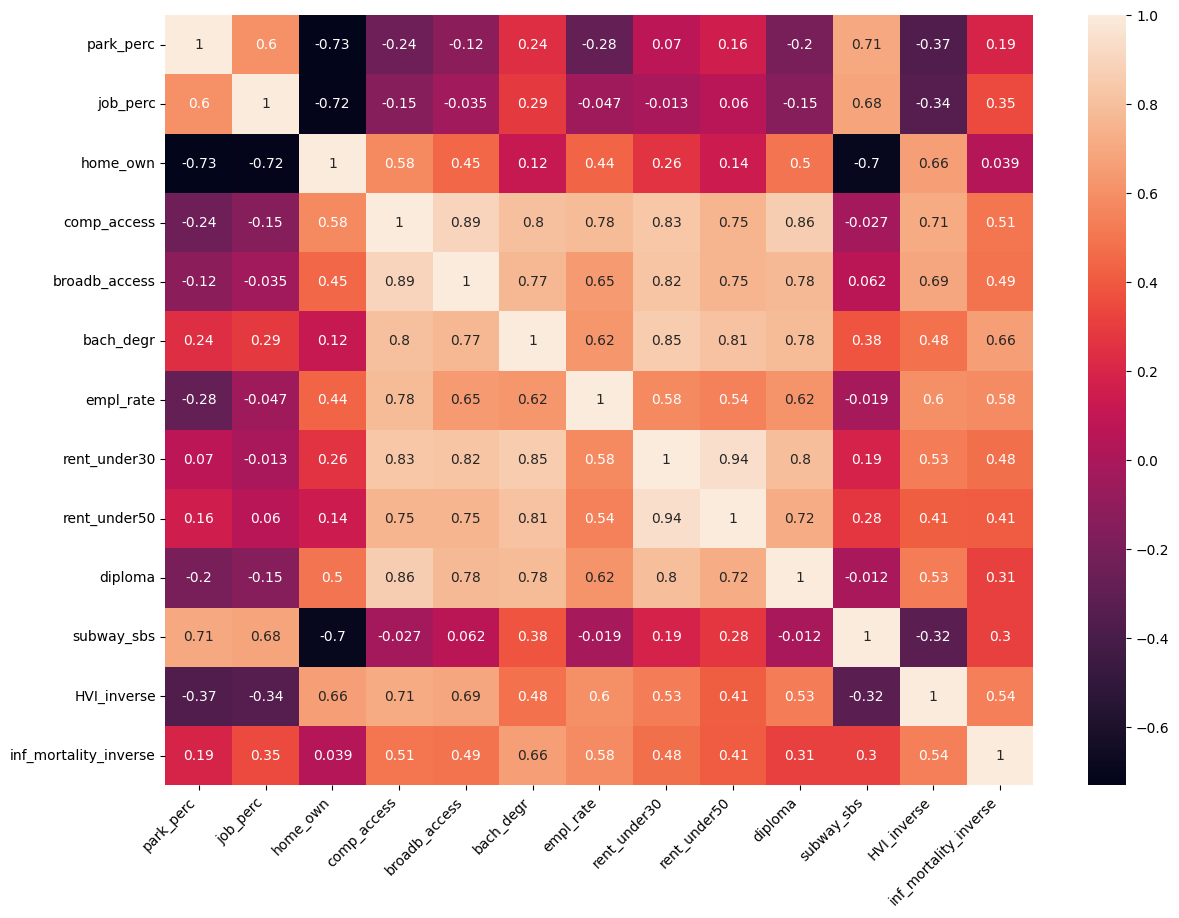

In [25]:
plt.subplots(figsize=(14,10))
ax_heatmap = sns.heatmap(X.corr(), annot = True)
ax_heatmap.set_xticks(ax_heatmap.get_xticks(), ax_heatmap.get_xticklabels(), rotation=45, ha='right')

save_figure(ax_heatmap, f"{OUTPUT_PATH_PREFIX}correlation_heatmap.png")
ax_heatmap

### Variable Sets
 
##### These variations of 8 indicators selected based on Silhoutte scores, Elbow method in archived 'master' notebook
"Condensed" set 1 (8 variables) - park access, job access, computer access, *bachelor's degree*, employment rate, *rent under 30% of HH income*, subway and bus access, infant mortality rate

"Condensed" set 2 (8 variables) - park access, job access, computer access, *high school diploma*, employment rate, *rent under 30% of HH income*, subway and bus access, infant mortality rate

"Condensed" set 3 (8 variables) - park access, job access, computer access, *bachelor's degree*, employment rate, *rent under 50% of HH income*, subway and bus access, infant mortality rate

"Condensed" set 4 (8 variables) - park access, job access, computer access, *high school diploma*, employment rate, *rent under 50% of HH income*, subway and bus access, infant mortality rate

In [26]:
cols_1C = ['PUMA','park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_2C = ['PUMA','park_perc','job_perc','comp_access','diploma','empl_rate','rent_under30','subway_sbs','inf_mortality_inverse']
cols_3C = ['PUMA','park_perc','job_perc','comp_access','bach_degr','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']
cols_4C = ['PUMA','park_perc','job_perc','comp_access','diploma','empl_rate','rent_under50','subway_sbs','inf_mortality_inverse']

df_1C = df_inputs.loc[:, cols_1C]
C1 = df_1C.iloc[:,1:]
df_2C = df_inputs.loc[:, cols_2C]
C2 = df_2C.iloc[:,1:]
df_3C = df_inputs.loc[:, cols_3C]
C3 = df_3C.iloc[:,1:]
df_4C = df_inputs.loc[:, cols_4C]
C4 = df_4C.iloc[:,1:]
C1.head()

,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse
0,91.5,89.9,75.5,40.6,93.0,46.1,23.991322,66.1489
1,63.4,46.9,68.2,24.4,90.6,39.3,32.176729,32.2076
2,49.9,36.4,73.9,26.3,92.4,50.3,13.331543,68.4940
3,84.5,88.5,71.6,24.5,91.5,41.8,44.007477,49.4949
4,99.2,100.0,54.6,12.8,87.4,36.1,39.494481,38.6646


### Standardization

##### Not needed for this exercise

#### Sample code:

In [27]:
# scaler = StandardScaler()
# scalerNum = scaler.fit(df)
# Xstd = scalerNum.transform(df)
# df_std = pd.DataFrame(Xstd)

### Silhouette and Elbow Methods:

##### K-Means

In [28]:
master_silhouette_list = []

In [29]:
counter = 0
for df in [C1, C2, C3, C4]:
    counter+=1
    for i in range(2,10):
        km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        cluster_labels = km.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
        master_silhouette_list.append(silhouette_avg)
        print('For dataset {} where n_clusters = {}, the average silhouette_score is: {}'.format(counter, i, silhouette_avg))

/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 1 where n_clusters = 2, the average silhouette_score is: 0.4242363101188807
For dataset 1 where n_clusters = 3, the average silhouette_score is: 0.3754201618336373
For dataset 1 where n_clusters = 4, the average silhouette_score is: 0.3607845268382209


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 1 where n_clusters = 5, the average silhouette_score is: 0.3507598825985386
For dataset 1 where n_clusters = 6, the average silhouette_score is: 0.30408913929796727


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 1 where n_clusters = 7, the average silhouette_score is: 0.2938379426470565
For dataset 1 where n_clusters = 8, the average silhouette_score is: 0.31407763340314
For dataset 1 where n_clusters = 9, the average silhouette_score is: 0.3154856354729771
For dataset 2 where n_clusters = 2, the average silhouette_score is: 0.45571085208434853


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: Th

For dataset 2 where n_clusters = 3, the average silhouette_score is: 0.30001838252286506
For dataset 2 where n_clusters = 4, the average silhouette_score is: 0.35246441443016463
For dataset 2 where n_clusters = 5, the average silhouette_score is: 0.30179565602344777
For dataset 2 where n_clusters = 6, the average silhouette_score is: 0.2849754753522472
For dataset 2 where n_clusters = 7, the average silhouette_score is: 0.2700356262680059


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: Th

For dataset 2 where n_clusters = 8, the average silhouette_score is: 0.2720552534420835


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 2 where n_clusters = 9, the average silhouette_score is: 0.2714220436904901
For dataset 3 where n_clusters = 2, the average silhouette_score is: 0.4268483885580666
For dataset 3 where n_clusters = 3, the average silhouette_score is: 0.36073813078363365


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 3 where n_clusters = 4, the average silhouette_score is: 0.35597857523322785
For dataset 3 where n_clusters = 5, the average silhouette_score is: 0.3478452695235683
For dataset 3 where n_clusters = 6, the average silhouette_score is: 0.29564710962746704
For dataset 3 where n_clusters = 7, the average silhouette_score is: 0.28545302823607577


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: Th

For dataset 3 where n_clusters = 8, the average silhouette_score is: 0.3102965720836076
For dataset 3 where n_clusters = 9, the average silhouette_score is: 0.2941651332746486
For dataset 4 where n_clusters = 2, the average silhouette_score is: 0.4593285173625881
For dataset 4 where n_clusters = 3, the average silhouette_score is: 0.3039995131665101


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: Th

For dataset 4 where n_clusters = 4, the average silhouette_score is: 0.34445258254095634
For dataset 4 where n_clusters = 5, the average silhouette_score is: 0.30359195774316133
For dataset 4 where n_clusters = 6, the average silhouette_score is: 0.2867143628559736


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For dataset 4 where n_clusters = 7, the average silhouette_score is: 0.26943619316306616
For dataset 4 where n_clusters = 8, the average silhouette_score is: 0.27237023898913476
For dataset 4 where n_clusters = 9, the average silhouette_score is: 0.2776096765845445


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: Th

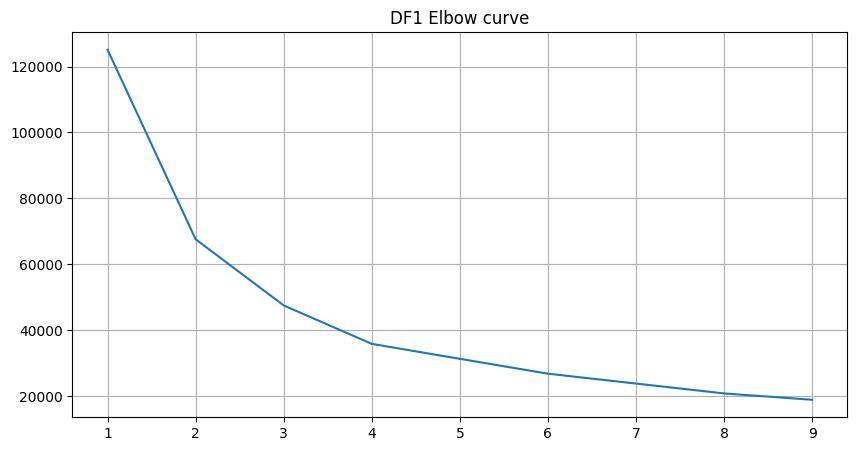

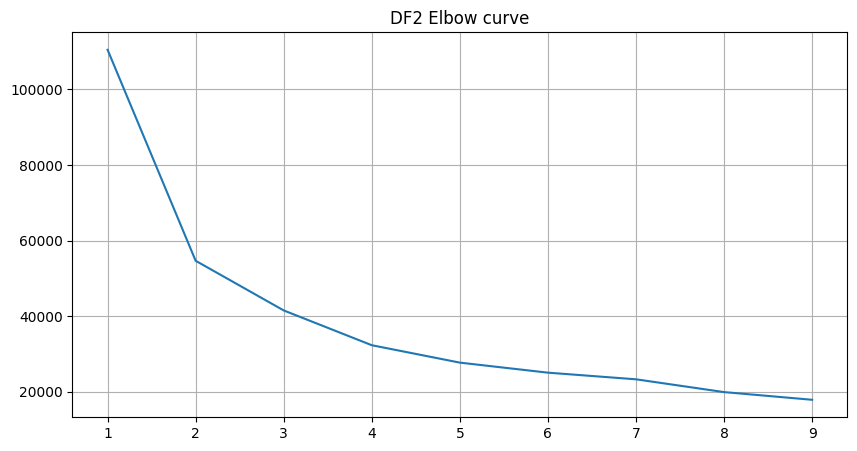

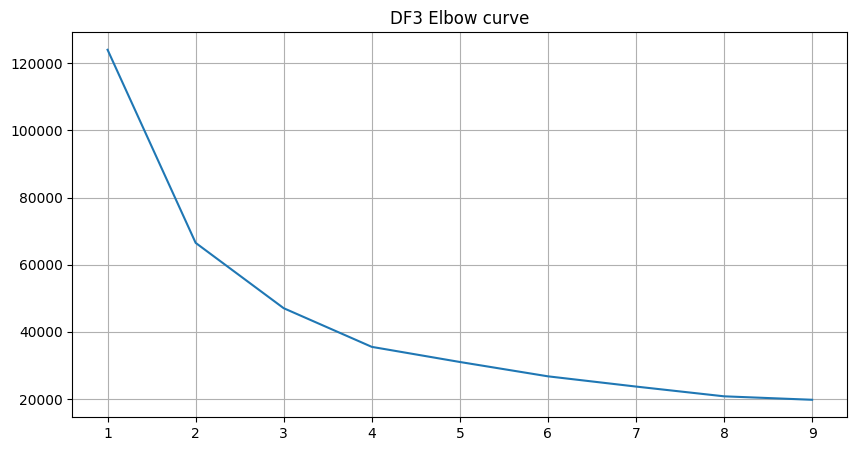

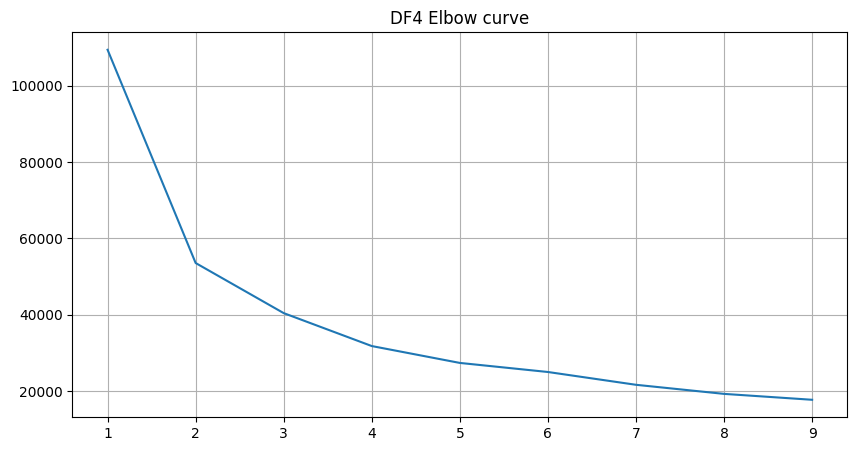

In [30]:
counter = 0
for df in [C1, C2, C3, C4]:
    counter+=1
    distorsions = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        distorsions.append(kmeans.inertia_)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(range(1, 10), distorsions)
    plt.grid(True)
    plt.title(f'DF{counter} Elbow curve')

## Clustering

Based on the Silhouette scores and Elbow coefficients, we'll take the following approach:
    
    * Model: K-means
    * Number of clusters: k=2 (silhoutte score = 0.46), k=4 (silhoutte score = 0.36)

    - For k=2, we'll use variable set 4 (park access, job access, computer access, high school diploma, employment rate, rent under 50% of HH income, subway and bus access, infant mortality rate)
    - For k=4, we'll use variable set 1 (park access, job access, computer access, bachelor's degree, employment rate, rent under 30% of HH income, subway and bus access, infant mortality rate)

### Trial 1
k=2, variable set 4

In [31]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
kmeans.fit(C2)
df_2C['labels'] = kmeans.labels_
cluster_sum1 = df_2C.groupby(['labels']).agg({'park_perc':'mean','job_perc':'mean',
                                                 'comp_access':'mean','diploma':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                  'subway_sbs':'mean','inf_mortality_inverse':'mean',
                                             'PUMA':'count'})
cluster_sum1.head()

/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,park_perc,job_perc,comp_access,diploma,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse,PUMA
labels,,,,,,,,,
0,86.525000,97.367500,74.66,80.995000,93.202500,46.8825,57.236210,65.205673,40
1,67.493333,39.493333,76.72,83.113333,93.513333,46.0200,22.260183,51.894540,15


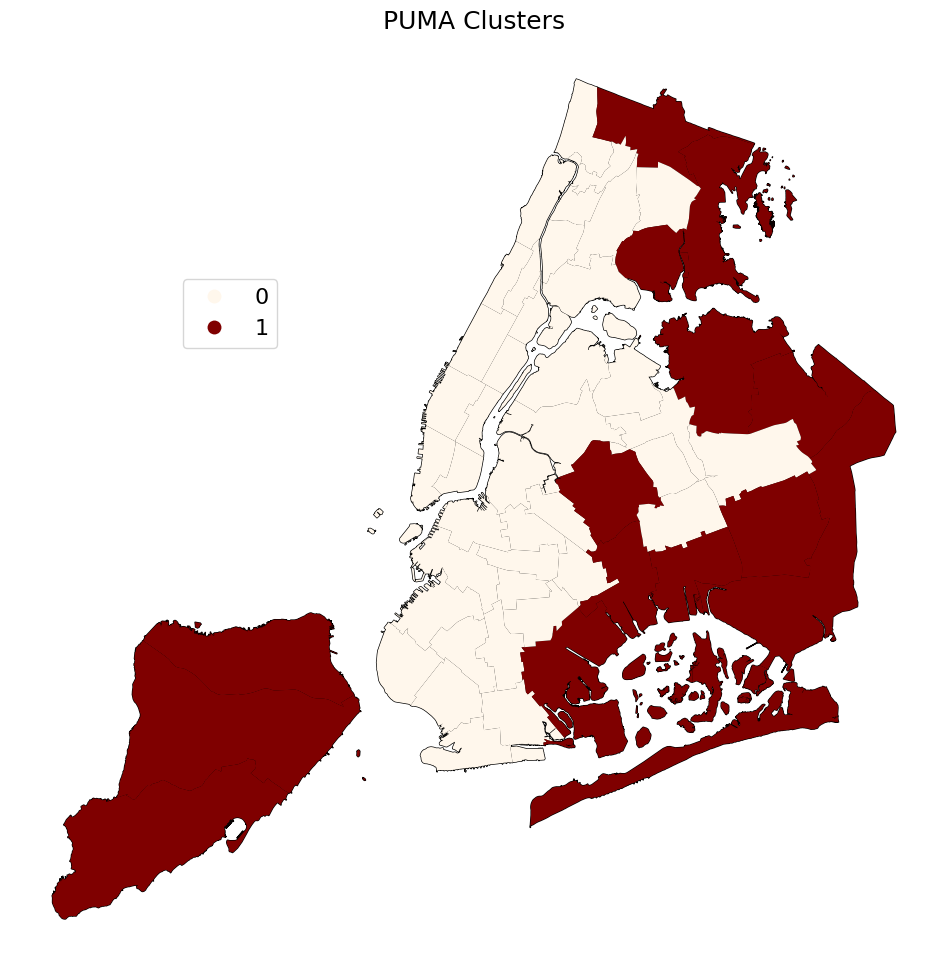

In [32]:
df_2C['puma'] = df_2C['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_2C, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(12,12))
ax = cluster_shapefile.plot(column='labels',categorical=True,legend=True, 
                            legend_kwds={'bbox_to_anchor':(.3, .75),'fontsize':16},
                            cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
plt.title('PUMA Clusters',size=18)
plt.show()

#### Results
Though reliable, this analysis is fairly uninteresting. The two clusters are divided along the lines of park access, job access and subway/bus station access, revealing an obvious divide between the center city's adjacent neighborhoods and more distant, lower density neighborhoods of NYC. See Trial 2 below.

### Trial 2
k=4, variable set 1

In [33]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 427)
kmeans.fit(C1)
df_1C['labels'] = kmeans.labels_
# Damon change reason:
# Cluster numbering was different than that of the original notebook/PDF
df_1C = set_cluster_labels(df_1C)
df_1C.head()
cluster_sum2 = df_1C.groupby(['labels']).agg({'park_perc':'mean','job_perc':'mean',
                                                 'comp_access':'mean','bach_degr':'mean',
                                                 'empl_rate':'mean','rent_under30':'mean',
                                                 'subway_sbs':'mean','inf_mortality_inverse':'mean',
                                             'PUMA':'count'})
cluster_sum2.head()

/Users/damonmccullough/github/NYC-Neighborhood-Clustering/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,park_perc,job_perc,comp_access,bach_degr,empl_rate,rent_under30,subway_sbs,inf_mortality_inverse,PUMA
labels,,,,,,,,,
Cluster 0\n(In-Between),75.547368,95.257895,75.336842,35.921053,94.000000,44.742105,43.734147,67.927079,19
Cluster 1\n(Accessible Infra. / Resource-Neglected),96.978571,98.914286,66.264286,28.064286,90.814286,42.971429,67.994487,52.827029,14
Cluster 2\n(Low Density Perim.),67.493333,39.493333,76.720000,27.926667,93.513333,46.020000,22.260183,51.894540,15
Cluster 3\n(Center City),95.414286,100.000000,89.614286,76.857143,95.814286,60.514286,72.368110,82.576286,7


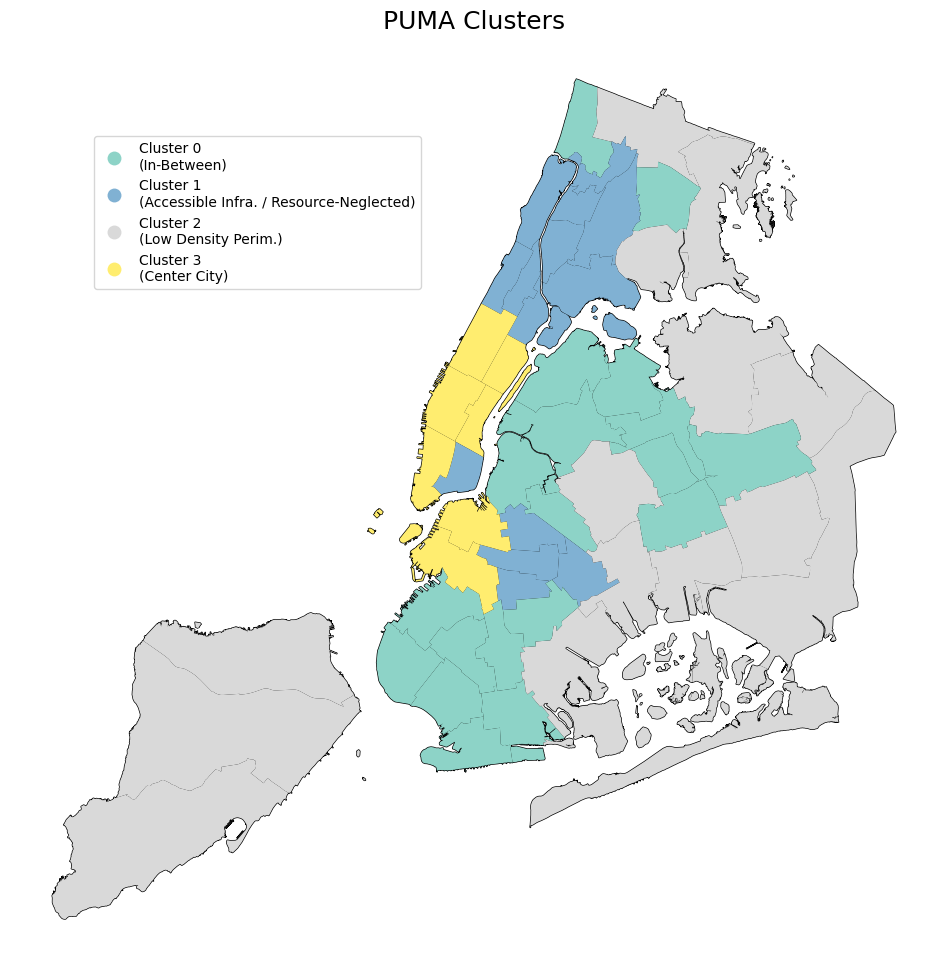

In [34]:
df_1C['puma'] = df_1C['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_1C, how='left', on='puma')
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(12,12))
ax_cluster_shapefile = cluster_shapefile.plot(column='labels',categorical=True,legend=True, 
                            legend_kwds={'bbox_to_anchor':(.45, .9),'fontsize':10},
                            cmap='Set3',ax=base)
ax_cluster_shapefile.set_aspect='equal'
ax_cluster_shapefile.axis('off')
# ax_cluster_shapefile.legend(["ha"], fontsize= 12 )
# plt.rc('legend', fontsize = 8)
plt.title('PUMA Clusters',size=18)
plt.show()

In [35]:
cluster_results_cleaned = clean_cluster_outputs(df_1C)
save_data_file(cluster_results_cleaned, f"{OUTPUT_PATH_PREFIX}results_cleaned.xlsx")
save_figure(ax_cluster_shapefile, f"{OUTPUT_PATH_PREFIX}map.png")

#### Results
This analysis is much more interesting in terms of its depiction of neighborhood-level quality of life and access to resources. The four clusters are divided along each of the input variables (park access, job access, computer access, bachelor's degree attainment, employment rate, affordable rent, subway/bus station access and infant mortality rate).

    * Cluster 3, the "Center City" cluster, has the highest score across each indicator, suggesting an overall greater level of resource access and quality of life than neighborhoods across the rest of the city.

    * Cluster 2, the "Low Density Perimeter" cluster includes lower density neighborhoods that are distant from the center city, which score low along the lines of job, park and subway access (and interestingly, infant morality, where a low score=high rate), and in the middle in terms of employment and computer access
    
    * Cluster 1, the "Infrastructure-Accessible, Resource-Neglected" cluster scores high in park, transit and job accessibility, but has the lowest scores in educational attainment, infant mortality, affordable rent and employment. Neighborhoods in this cluster are located conveniently, but quality of life indicators are low.
    
    * Cluster 0, the "In-Between" cluster has scores in the middle, with more decent quality of life indicator scores than Cluster 1, more accessibility to parks, jobs and subway stations than Cluster 2 but less than Cluster 1 or 3.

#### Cluster Demographics

    * Cluster 3 has the greatest share of White non-Hispanic residents and the highest median income
    
    * Cluster 1 has the lowest median income and greatest share of Black non-Hispanic and Hispanic residents
    
    * Clusters 0 and 2 are the most representative of NYC as a whole in terms of race and ethnicity makeup

In [36]:
demographic_df = pd.merge(hh_econ[["PUMA","MdHInc_19E"]], race_dec[['PUMA','WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']],
                         on='PUMA', how='inner')
master_cluster_df = pd.merge(df_1C, demographic_df, on='PUMA', how='inner').sort_values(by="labels")
save_data_file(master_cluster_df, f"{OUTPUT_PATH_PREFIX}results_full.xlsx")

inc_df = pd.merge(hh_econ[["PUMA","MdHInc_19E"]],
                  df_1C[['PUMA','labels']], on='PUMA', how='inner')
inc_df.rename(columns={"MdHInc_19E":'Median Income'},inplace=True)

inc_dfNYC = hh_econNYC[["MdHInc_19E"]]
inc_dfNYC.rename(columns={"MdHInc_19E":'Median Income'},inplace=True)
inc_dfNYC['labels']=['NYC']

race_df = pd.merge(race_dec[['PUMA','WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']],
                   df_1C[['PUMA','labels']], on='PUMA', how='inner')
race_df.rename(columns={"WNH20P":'White NH',"Hsp20P":'Hispanic',"BNH20P":'Black NH',"ANH20P":'Asian NH',
                       "OTwoNH20P":'Multi-Race NH'},inplace=True)

race_dfNYC = race_decNYC[['WNH20P','Hsp20P','BNH20P','ANH20P','OTwoNH20P']]
race_dfNYC.rename(columns={"WNH20P":'White NH',"Hsp20P":'Hispanic',"BNH20P":'Black NH',"ANH20P":'Asian NH',
                       "OTwoNH20P":'Multi-Race NH'},inplace=True)
race_dfNYC['labels']=['NYC']

/var/folders/51/ql0t6r6d6b9bmm7g496p1_f80000gq/T/ipykernel_27533/2026586961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_dfNYC.rename(columns={"MdHInc_19E":'Median Income'},inplace=True)
/var/folders/51/ql0t6r6d6b9bmm7g496p1_f80000gq/T/ipykernel_27533/2026586961.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_dfNYC['labels']=['NYC']
/var/folders/51/ql0t6r6d6b9bmm7g496p1_f80000gq/T/ipykernel_27533/2026586961.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

<Axes: xlabel='labels'>

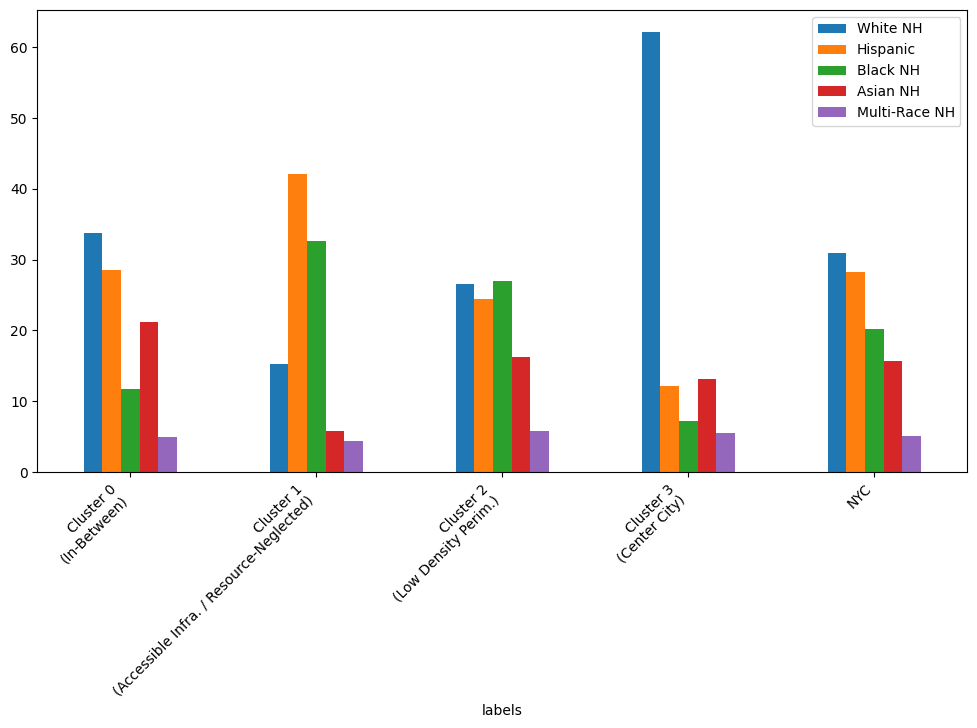

In [37]:
cluster_race = race_df.groupby(['labels']).agg({'White NH':'mean','Hispanic':'mean',
                                                 'Black NH':'mean','Asian NH':'mean',
                                                 'Multi-Race NH':'mean'}).reset_index()
# Damon change reason:
# AttributeError: 'DataFrame' object has no attribute 'append'
# cluster_race = cluster_race.append(race_dfNYC)
cluster_race = pd.concat([cluster_race, race_dfNYC], axis=0)

columns_to_round = [
    "White NH",
    "Hispanic",
    "Black NH",
    "Asian NH",
    "Multi-Race NH"
]
cluster_race = round_percentage_data(cluster_race, columns_to_round)
ax_cluster_race = cluster_race.plot.bar(x='labels',figsize=(12,6))

ax_cluster_race.set_xticks(ax_cluster_race.get_xticks(), ax_cluster_race.get_xticklabels(), rotation=45, ha='right')
ax_cluster_race

In [38]:
type(ax_cluster_race)

matplotlib.axes._axes.Axes

In [39]:
save_data_file(cluster_race, f"{OUTPUT_PATH_PREFIX}demographics.csv")
save_figure(ax_cluster_race, f"{OUTPUT_PATH_PREFIX}demographics.png")

<Axes: xlabel='labels'>

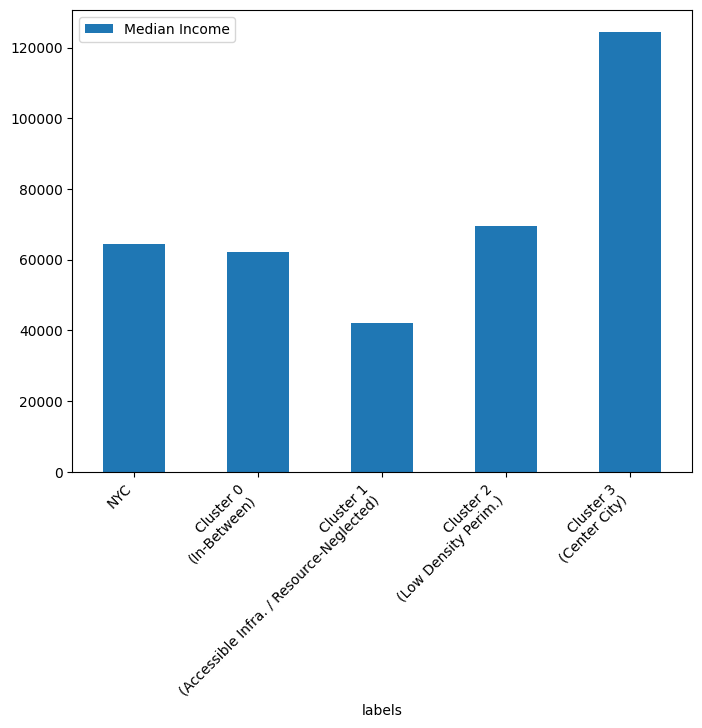

In [40]:
cluster_inc = inc_df.groupby(['labels']).agg({'Median Income':'mean'}).reset_index()
# Damon change reason:
# AttributeError: 'DataFrame' object has no attribute 'append'
# cluster_inc = cluster_inc.append(inc_dfNYC)
cluster_inc = pd.concat([inc_dfNYC, cluster_inc], axis=0)
ax_cluster_inc = cluster_inc.plot.bar(x='labels',figsize=(8,6))

ax_cluster_inc.set_xticks(ax_cluster_inc.get_xticks(), ax_cluster_inc.get_xticklabels(), rotation=45, ha='right')
ax_cluster_inc

In [41]:
save_figure(ax_cluster_inc, f"{OUTPUT_PATH_PREFIX}income.png")

#### Note:
See 'Neighborhood Clustering Analysis Results Deck.pdf' and 'outputs/cluster_8v_results_full.xlsx' in repository for more detailed Trial 2 clustering results.